## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (182 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
import matplotlib.patches as patches
import random
import cv2
import openslide

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def get_images(lst, slide, tumor_mask):
  for i in lst:
    slide_path = '/content/drive/My Drive/slide/Copy of tumor_{}.tif'.format(i)
    mask_path = '/content/drive/My Drive/slide/Copy of tumor_{}_mask.tif'.format(i)
    slide_image = open_slide(slide_path)
    mask_image = open_slide(mask_path)
    slide.append(slide_image)
    tumor_mask.append(mask_image)

  return slide, tumor_mask

# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))


def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [ ]:
def checkcancer(mask, start, end, off):
  midx = midy = (start + end) // 2

  x_lower, x_upper = midx - off//2, midx + off//2
  y_lower, y_upper = midy - off//2, midy + off//2

  # Check is the 128 X 128 region contain cancer cell
  p = np.sum(mask[x_lower: x_upper, y_lower : y_upper])
 
  return p > 100

In [ ]:
def plot_images(slide_image, mask_image):
    offset = 64
    fig, axes = plt.subplots(1,2, figsize=(7,7))
    midx = midy = 299 // 2
    a = axes[0]
    a.set_title("image")
    a.imshow(slide_image)

    a = axes[1]
    a.set_title('masked image ')
    a.imshow(slide_image)
    a.imshow(mask_image, cmap='jet', alpha=0.5)  
    # plot a 128 X 128 square detect region
    a.plot([midx - offset, midx - offset, midx + offset, midx + offset,midx - offset ],
                [midy - offset, midy + offset, midy + offset, midy - offset, midy - offset], 'g')

In [ ]:
def sliding_windows(picture,  level_num, patch_size, mask_picture):
  # parameters
  downsize_factor =pow(2, level_num)
  True_slide_images, True_slide_mask = [], []
  False_slide_images = []
  tissue_regions = []

  slide = picture
  mask = mask_picture
  offset = 64
  row = slide.level_dimensions[level_num][0]
  col = slide.level_dimensions[level_num][1]
  
  # sliding windows
  for i in range(0, col - patch_size, patch_size):
    y_start = i
 
    
    for j in range(0, row - patch_size, patch_size):
      x_start = j
      #print(x_start, y_start)
      #image slide
      
      slide_image = read_slide(slide, 
                         x= x_start * downsize_factor, 
                         y= y_start * downsize_factor, 
                         level= level_num, 
                         width= patch_size, 
                         height= patch_size)
    # mask slide
      mask_image = read_slide(mask, 
                         x= x_start * downsize_factor, 
                         y= y_start * downsize_factor, 
                         level= level_num, 
                         width= patch_size, 
                         height= patch_size)
      # masks used on image
      mask_image_verify = mask_image[:,:,0]

      label = checkcancer(mask_image_verify, 0, 299, 128)

      #collection True data and False data
      if label:
        True_slide_images.append(slide_image)
        True_slide_mask.append(mask_image_verify)
      else:
        False_slide_images.append(slide_image)
        
     


      # visualize
      #plot_images(slide_image, mask_image_verify, level_num )
      # if contain cancer, zoom out and collection image
        

      
  return True_slide_images, False_slide_images, True_slide_mask

In [ ]:
def heatmap(picture,  level_num, patch_size, mask_array, mask_picture):
  # parameters
  downsize_factor =pow(2, level_num)
  slide = picture
  offset = 64
  mask_copy = mask_array.copy()
  mask = mask_picture
  res = []
  row = slide.level_dimensions[level_num][0]
  col = slide.level_dimensions[level_num][1]
  # sliding windows
  for i in range(0, col - patch_size, patch_size):
    y_start = i
    for j in range(0, row - patch_size, patch_size):
      x_start = j
      #print(x_start, y_start)
      #image slide
      slide_image = read_slide(slide, 
                         x= x_start * downsize_factor, 
                         y= y_start * downsize_factor, 
                         level= level_num, 
                         width= patch_size, 
                         height= patch_size)  # mask slide

      m_image = read_slide(mask, 
                         x= x_start * downsize_factor, 
                         y= y_start * downsize_factor, 
                         level= level_num, 
                         width= patch_size, 
                         height= patch_size)
      # masks used on image
      mask_image_verify = m_image[:,:,0]

      label = checkcancer(mask_image_verify, 0, 299, 128)
      # masks used on image
      im_batch = tf.expand_dims(slide_image, axis=0)
      result = loaded_model.predict(im_batch)
      idx = np.argmax(result, axis = 1)
      result = markers[int(idx)]
      #print(result)
      #print(label)
      if result == 'True' and label == False:
        mask_copy[(i + i+299)//2 - 64 : (i+i+ 299) //2 + 64, (j+j+299)//2 - 64 : (j+j+ 299) //2 + 64] = 125
      if result == 'True' and label == True:
        mask_copy[i : i+299, j : j + 299] = 125
      if result == 'False' and label == True:
        mask_copy[i : i+299, j : j + 299] = 0
      

        

      
  return mask_copy

In [ ]:
def collectionimage(picture,  level_num, patch_size, mask_picture):
  # parameters
  downsize_factor =pow(2, level_num)
  True_slide_images, True_slide_mask = [], []
  False_slide_images = []
  y_actual = []
  x_test = []

  slide = picture
  mask = mask_picture
  offset = 64
  row = slide.level_dimensions[level_num][0]
  col = slide.level_dimensions[level_num][1]
  
  # sliding windows
  for i in range(0, col - patch_size, patch_size):
    y_start = i
 
    
    for j in range(0, row - patch_size, patch_size):
      x_start = j
      #print(x_start, y_start)
      #image slide
      
      slide_image = read_slide(slide, 
                         x= x_start * downsize_factor, 
                         y= y_start * downsize_factor, 
                         level= level_num, 
                         width= patch_size, 
                         height= patch_size)
    # mask slide
      mask_image = read_slide(mask, 
                         x= x_start * downsize_factor, 
                         y= y_start * downsize_factor, 
                         level= level_num, 
                         width= patch_size, 
                         height= patch_size)
      # masks used on image
      mask_image_verify = mask_image[:,:,0]

      label = checkcancer(mask_image_verify, 0, 299, 128)

      #collection True data and False data
      if label:
        True_slide_images.append(slide_image)
        True_slide_mask.append(mask_image_verify)
        y_actual.append('True')
      else:
        False_slide_images.append(slide_image)
        y_actual.append('False')
      
      x_test.append(slide_image)
     


      # visualize
      #plot_images(slide_image, mask_image_verify, level_num )
      # if contain cancer, zoom out and collection image
        

      
  return True_slide_images, False_slide_images, True_slide_mask, x_test, y_actual

# Test Starter Code

In [ ]:
for i in range(len(slides)):
  #print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
  #                                                      slide.level_dimensions[0][0], 
  #    
  #                                                  slide.level_dimensions[0][1]))

  # read slide image
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=6, 
                         width=slides[i].level_dimensions[6][0], 
                         height=slides[i].level_dimensions[6][1])

  plt.figure(figsize=(4,4), dpi=100)
  plt.imshow(slide_image)
  # read mask image

  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=6, 
                        width=slides[i].level_dimensions[6][0], 
                        height=slides[i].level_dimensions[6][1])

  mask_image = mask_image[:,:,0]
  #print(len(sum(mask_image)))
  plt.figure(figsize=(3,3), dpi=100)
  plt.imshow(mask_image)
  # overlay

  mask_image2 = read_slide(tumor_masks[i], 
                        x=250 * 128, 
                        y= 220 * 128, 
                        level=7, 
                        width= 21, 
                        height= 24)
 


  #plt.imshow(slide_image)
  #plt.imshow(mask_image, cmap='jet', alpha=0.5)

  
  tissue_pixels = find_tissue_pixels(slide_image)
  ymintissue = sorted(tissue_pixels, key = lambda x:x[1])
  print(tissue_pixels[0], tissue_pixels[-1])
  print(ymintissue[0], ymintissue[-1])
  #print(tissue_pixels)
  #percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
  #print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 
  #plt.imshow(tissue_pixels)
  tissue_regions = apply_mask(slide_image, tissue_pixels)
  plt.imshow(tissue_regions)

NameError: ignored

# Collect Data

In [ ]:
True_image = []
False_image = []

8 Training Sets and 2 Validation sets
extracted at level 2, 3, 4, 5, with 
window 299X299

In [ ]:
image_list = ['091','101','078','110'] 
test_list = [ '075']
level_array = [2,3,4,6]

Collect Cancer Data and Non Cancer Data at difference level

In [ ]:
slides, tumor_masks = get_images(['084'], [],[])
for i in range(len(slides)):

  True_data, False_data, True_mask = sliding_windows(slides[i], 4, 299, tumor_masks[i])

In [ ]:
#for i in range(len(True_data)):
#  plot_images(True_data[i], True_mask[i])

## Collect data in image '091'

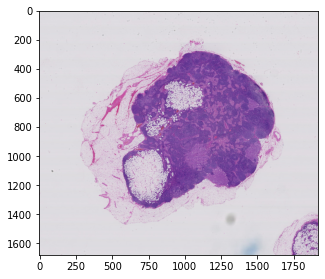

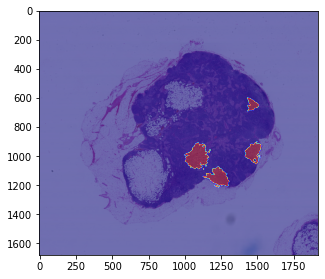

In [ ]:
slides, tumor_masks = get_images(['091'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [ ]:
True_91_image = []
False_91_image = []
True_91_mask = []

for i in level_array:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_91_image += True_data 
  False_91_image += False_data
  True_91_mask += True_mask

Plot some data

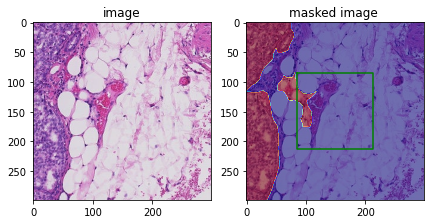

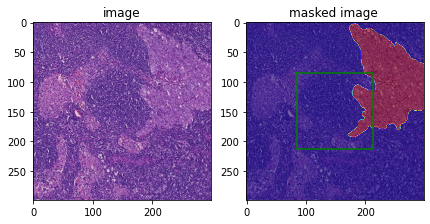

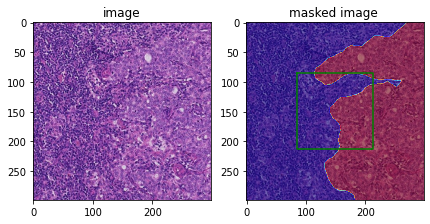

In [ ]:
for i in range(3):
  n = random.randint(0, len(True_91_image) - 1)
  plot_images(True_91_image[n], True_91_mask[n])

In [ ]:
random.shuffle(True_91_image)
random.shuffle(False_91_image)
Train_true_image, validation_true_image = True_91_image[len(True_91_image)//4 :], True_91_image[: len(True_91_image)//4]
Train_false_image, validation_false_image = False_91_image[:len(False_91_image)//3], False_91_image[len(False_91_image)//3 :]

Save Image

In [ ]:
#for i in range(len(Train_true_image)):
#  True_X_train_filename = '/content/drive/My Drive/Cell/Test/True/image91_{}.png'.format(i)
#  plt.imshow(Train_true_image[i])
#  cv2.imwrite(True_X_train_filename,Train_true_image[i])

In [ ]:
#for i in range(len(validation_true_image)):
##  False_X_train_filename = '/content/drive/My Drive/Cell/Validation/True/image91_{}.png'.format(i)
#  plt.imshow(validation_true_image[i])
#  cv2.imwrite(False_X_train_filename,validation_true_image[i])

## Collect data in image '101'

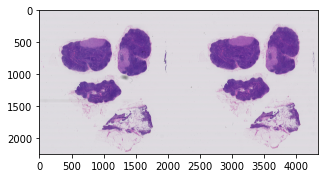

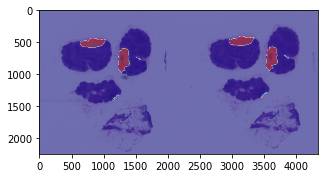

In [ ]:
slides, tumor_masks = get_images(['101'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [ ]:
True_101_image = []
False_101_image = []
True_101_mask = []

for i in level_array:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_101_image += True_data 
  False_101_image += False_data
  True_101_mask += True_mask

Plot some data

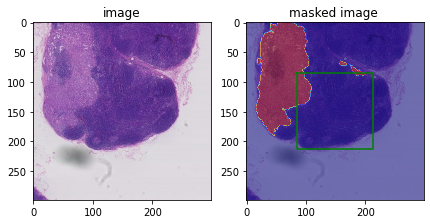

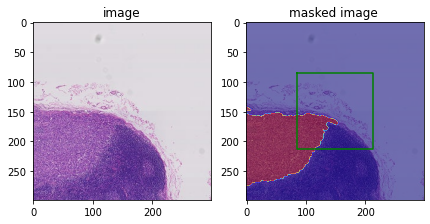

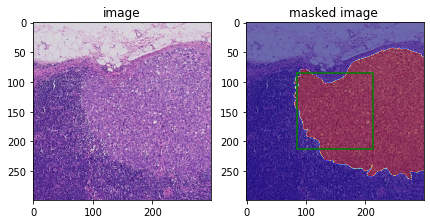

In [ ]:
for i in range(3):
  n = random.randint(0, len(True_101_image) - 1)
  plot_images(True_101_image[n], True_101_mask[n])

In [ ]:
random.shuffle(True_101_image)
random.shuffle(False_101_image)
Train_true_image, validation_true_image = True_101_image[len(True_101_image)//4 :], True_101_image[: len(True_101_image)//4]
Train_false_image, validation_false_image = False_101_image[:len(False_101_image)//3], False_101_image[len(False_101_image)//3 :]

In [ ]:
#for i in range(len(Train_true_image)):
  #True_X_train_filename = '/content/drive/My Drive/Cell/Test/True/image101_{}.png'.format(i)
  #plt.imshow(Train_true_image[i])
  #cv2.imwrite(True_X_train_filename,Train_true_image[i])

In [ ]:
#for i in range(len(validation_true_image)):
#  False_X_train_filename = '/content/drive/My Drive/Cell/Validation/True/image101_{}.png'.format(i)
#  plt.imshow(validation_true_image[i])
#  cv2.imwrite(False_X_train_filename,validation_true_image[i])

## Collect data in image '078'

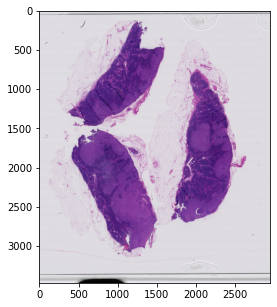

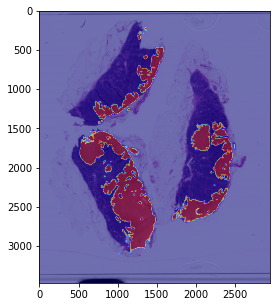

In [ ]:
slides, tumor_masks = get_images(['078'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [ ]:
True_078_image = []
False_078_image = []
True_078_mask = []

for i in level_array:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_078_image += True_data 
  False_078_image += False_data
  True_078_mask += True_mask

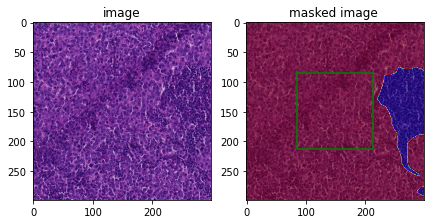

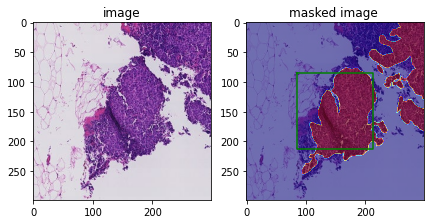

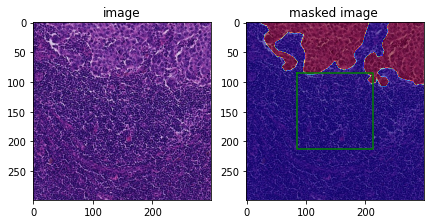

In [ ]:
for i in range(3):
  n = random.randint(0, len(True_078_image) - 1)
  plot_images(True_078_image[n], True_078_mask[n])

In [ ]:
random.shuffle(True_078_image)
random.shuffle(False_078_image)
Train_true_image, validation_true_image = True_078_image[len(True_078_image)//4 :], True_078_image[: len(True_078_image)//4]
Train_false_image, validation_false_image = False_078_image[:len(False_078_image)//3], False_078_image[len(False_078_image)//3 :]

In [ ]:
#for i in range(len(Train_true_image)):
#  True_X_train_filename = '/content/drive/My Drive/Cell/Test/True/image078_{}.png'.format(i)
#  plt.imshow(Train_true_image[i])
#  cv2.imwrite(True_X_train_filename,Train_true_image[i])

In [ ]:
#for i in range(len(validation_true_image)):
##  False_X_train_filename = '/content/drive/My Drive/Cell/Validation/True/image078_{}.png'.format(i)
 # plt.imshow(validation_true_image[i])
 # cv2.imwrite(False_X_train_filename,validation_true_image[i])

## Collect data in image '110'

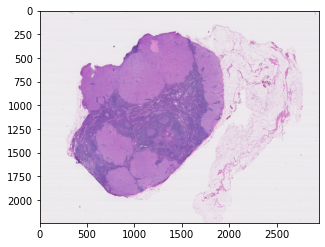

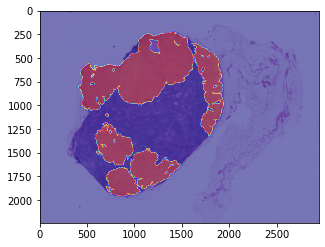

In [ ]:
slides, tumor_masks = get_images(['110'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

In [ ]:
True_110_image = []
False_110_image = []
True_110_mask = []

for i in level_array:
  True_data, False_data, True_mask = sliding_windows(slides[0], i, 299, tumor_masks[0])
  True_110_image += True_data 
  False_110_image += False_data
  True_110_mask += True_mask

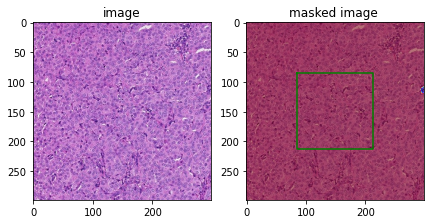

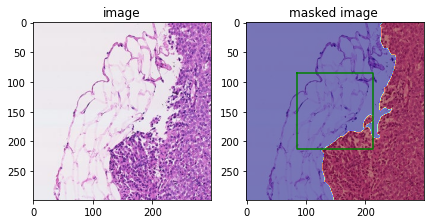

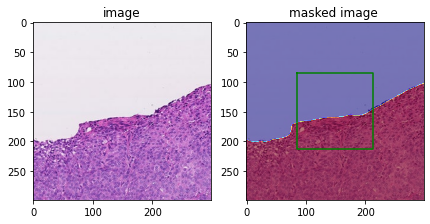

In [ ]:
for i in range(3):
  n = random.randint(0, len(True_110_image) - 1)
  plot_images(True_110_image[n], True_110_mask[n])

In [ ]:
random.shuffle(True_110_image)
random.shuffle(False_110_image)
Train_true_image, validation_true_image = True_110_image[len(True_110_image)//4 :], True_110_image[ : len(True_110_image)//4]
Train_false_image, validation_false_image = False_110_image[:len(False_110_image)//3], False_110_image[len(False_110_image)//3 :]

In [ ]:
#for i in range(len(Train_true_image)):
#  True_X_train_filename = '/content/drive/My Drive/Cell/Test/True/image110_{}.png'.format(i)
#  plt.imshow(Train_true_image[i])
#  cv2.imwrite(True_X_train_filename,Train_true_image[i])

In [ ]:
#for i in range(len(validation_true_image)):
#  False_X_train_filename = '/content/drive/My Drive/Cell/Validation/True/image110_{}.png'.format(i)
#  plt.imshow(validation_true_image[i])
#  cv2.imwrite(False_X_train_filename,validation_true_image[i])

In [ ]:
Train_True_dir = '/content/drive/My Drive/Cell/Test/True'
#print(len(os.listdir(Train_True_dir)))

In [ ]:
Train_False_dir = '/content/drive/My Drive/Cell/Test/False'
#print(len(os.listdir(Train_False_dir)))

In [ ]:
Valid_True_dir = '/content/drive/My Drive/Cell/Validation/True'
#print(len(os.listdir(Valid_True_dir)))

In [ ]:
Valid_False_dir = '/content/drive/My Drive/Cell/Validation/False'
#print(len(os.listdir(Valid_False_dir)))

## Load Data from Colab

In [ ]:
import os, shutil
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from tensorflow.keras import preprocessing
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
train_dir = '/content/drive/My Drive/Cell/Test'
valid_dir = '/content/drive/My Drive/Cell/Validation'

In [ ]:
markers = ['False', 'True']

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255)
    #rotation_range=10,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32 ,
    shuffle=True)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(299, 299),
    batch_size=32,
    shuffle=True)

Found 1963 images belonging to 2 classes.
Found 705 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    #print(labels_batch)
    break

data batch shape: (32, 299, 299, 3)
labels batch shape: (32, 2)


# Train Deep Learning Model

In [ ]:
import os, shutil
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from sklearn.metrics import confusion_matrix
import pandas as pd


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(299, 299, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

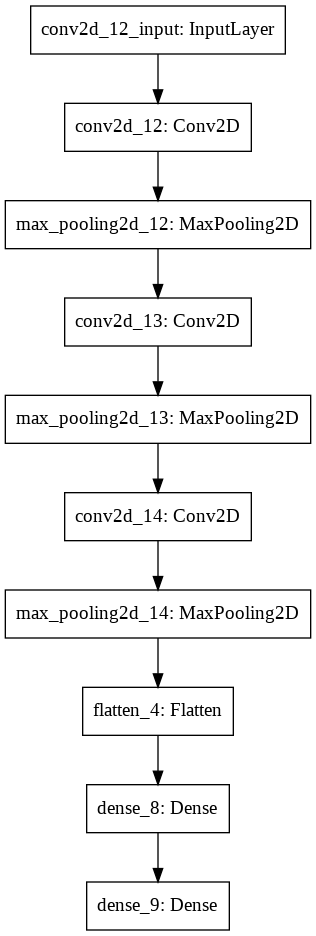

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(
      train_generator,
      epochs=5,
      validation_data = validation_generator)

Epoch 1/5
62/62 [==============================] - 18s 287ms/step - loss: 1.8424 - acc: 0.6531 - val_loss: 0.4383 - val_acc: 0.7645
Epoch 2/5
62/62 [==============================] - 18s 283ms/step - loss: 0.4375 - acc: 0.7687 - val_loss: 0.2275 - val_acc: 0.8993
Epoch 3/5
62/62 [==============================] - 18s 285ms/step - loss: 0.3436 - acc: 0.8548 - val_loss: 0.2568 - val_acc: 0.9078
Epoch 4/5
62/62 [==============================] - 18s 289ms/step - loss: 0.2557 - acc: 0.8935 - val_loss: 0.2014 - val_acc: 0.9291
Epoch 5/5
62/62 [==============================] - 18s 286ms/step - loss: 0.2997 - acc: 0.8767 - val_loss: 0.2879 - val_acc: 0.8738


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 297, 297, 64)      1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 148, 148, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 146, 146, 128)     73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 73, 73, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 71, 71, 512)       590336    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 35, 35, 512)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 627200)           

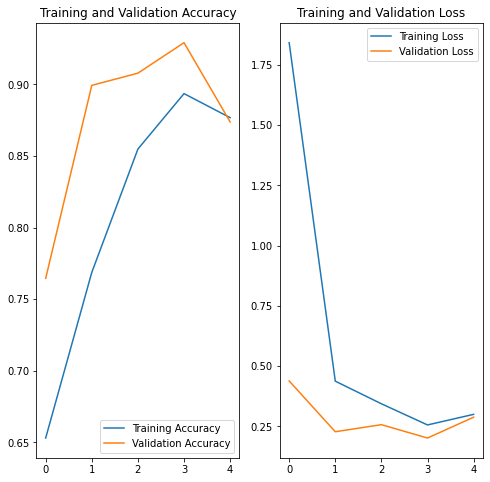

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# load json and create model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


## Use '084' "081" as Test Image Plot heatmap and confusion matrix

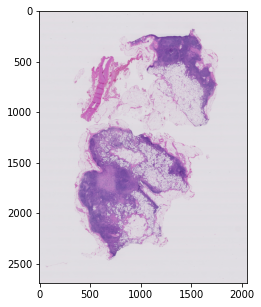

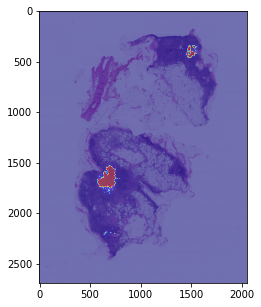

In [ ]:
slides, tumor_masks = get_images(['084'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

True_084_image = []
False_084_image = []
True_084_mask = []

for i in [5]:
  True_data, False_data, True_mask, x_test, y_actual = collectionimage(slides[0], i, 299, tumor_masks[0])
  True_084_image += True_data 
  False_084_image += False_data
  True_084_mask += True_mask

In [ ]:
predict_true = []
for image in True_084_image:
  im_batch = tf.expand_dims(image, axis=0)
  result = loaded_model.predict(im_batch)
  idx = np.argmax(result, axis = 1)
  predict_true.append(markers[int(idx)])

predict_false = []
for image in False_084_image:
  im_batch = tf.expand_dims(image, axis=0)
  result = loaded_model.predict(im_batch)
  idx = np.argmax(result, axis = 1)
  predict_false.append(markers[int(idx)])
  
True_matrix = ['True'] * len(predict_true)
False_matrix = ['False'] * len(predict_false)


In [ ]:
actual = True_matrix + False_matrix
predict = predict_true + predict_false
y_actu = pd.Series(actual, name='Actual')
y_pred = pd.Series(predict, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print('The confusion Matrix is')
print('----------------------------------------')
df_confusion

The confusion Matrix is
----------------------------------------


Predicted,False,True
Actual,,
False,39,7
True,0,2


In [ ]:
TP = df_confusion.iloc[0][0] + df_confusion.iloc[1][1]
FP = df_confusion.iloc[0][1] + df_confusion.iloc[1][0]
FN = df_confusion.iloc[0][1]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)

print('The Precision of that model is:', round(Precision, 4))
print('The Recall of that model is:', round(Recall, 4))

The Precision of that model is: 0.8542
The Recall of that model is: 0.8542


In [ ]:
for i in [5]:
  res = heatmap(slides[0], i, 299, mask_image, tumor_masks[0])

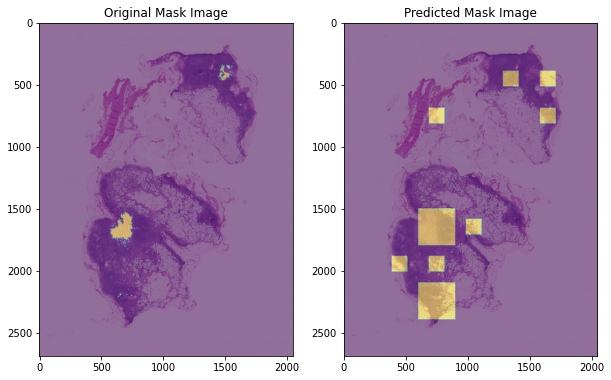

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(slide_image)
plt.imshow(mask_image, alpha=0.5)
plt.title('Original Mask Image')

plt.subplot(1, 2, 2)
plt.imshow(slide_image)
plt.imshow(res, alpha=0.5)
plt.title('Predicted Mask Image')
plt.show()

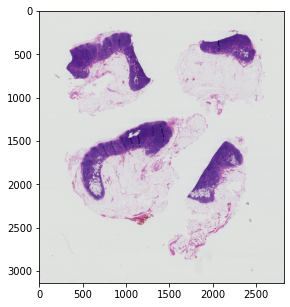

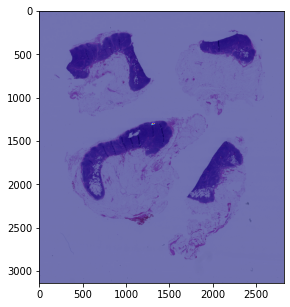

In [ ]:
slides, tumor_masks = get_images(['081'], [],[])
for i in range(len(slides)):
  slide_image = read_slide(slides[i], 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slides[i].level_dimensions[5][0], 
                         height=slides[i].level_dimensions[5][1])

  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)


  mask_image = read_slide(tumor_masks[i], 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slides[i].level_dimensions[5][0], 
                        height=slides[i].level_dimensions[5][1])
  mask_image = mask_image[:,:,0]
  plt.figure(figsize=(5,5))
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

True_081_image = []
False_081_image = []
True_081_mask = []

for i in [5]:
  True_data, False_data, True_mask, x_test, y_actual = collectionimage(slides[0], i, 299, tumor_masks[0])
  True_081_image += True_data 
  False_081_image += False_data
  True_081_mask += True_mask

In [ ]:
predict_true = []
for image in True_081_image:
  im_batch = tf.expand_dims(image, axis=0)
  result = loaded_model.predict(im_batch)
  idx = np.argmax(result, axis = 1)
  predict_true.append(markers[int(idx)])

predict_false = []
for image in False_081_image:
  im_batch = tf.expand_dims(image, axis=0)
  result = loaded_model.predict(im_batch)
  idx = np.argmax(result, axis = 1)
  predict_false.append(markers[int(idx)])
  
True_matrix = ['True'] * len(predict_true)
False_matrix = ['False'] * len(predict_false)

actual = True_matrix + False_matrix
predict = predict_true + predict_false
y_actu = pd.Series(actual, name='Actual')
y_pred = pd.Series(predict, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print('The confusion Matrix is')
print('----------------------------------------')
df_confusion

The confusion Matrix is
----------------------------------------


Predicted,False,True
Actual,,
False,83,6
True,1,0


In [ ]:
TP = df_confusion.iloc[0][0] + df_confusion.iloc[1][1]
FP = df_confusion.iloc[0][1] + df_confusion.iloc[1][0]
FN = df_confusion.iloc[0][1]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)

print('The Precision of that model is:', round(Precision, 4))
print('The Recall of that model is:', round(Recall, 4))

The Precision of that model is: 0.9222
The Recall of that model is: 0.9326


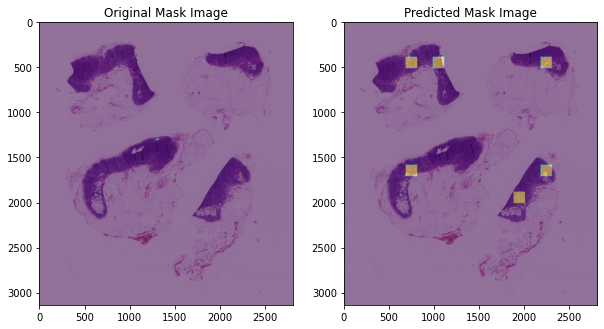

In [ ]:
for i in [5]:
  res = heatmap(slides[0], i, 299, mask_image, tumor_masks[0])

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(slide_image)
plt.imshow(mask_image, alpha=0.5)
plt.title('Original Mask Image')

plt.subplot(1, 2, 2)
plt.imshow(slide_image)
plt.imshow(res, alpha=0.5)
plt.title('Predicted Mask Image')
plt.show()